In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
from sklearn import datasets
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 



In [2]:
#import train and test set from UCI links

train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)

test = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital_status', 'occupation','relationship', 
              'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train.columns = col_labels
test.columns = col_labels

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
train.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
train.describe()


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
#find out numerical and categorical features for test set

numerical_features_test=[feature for feature in test.columns if test[feature].dtype!='O']
categorical_features_test=[feature for feature in  test.columns if  test[feature].dtype=='O' and feature!='wage_class']

print('categorical features: ''\n',categorical_features_test)
print('\n')
print('numerical features: ''\n',numerical_features_test)

categorical features: 
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


numerical features: 
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [7]:
#Check for missing values
for feature in test.columns:
    print(feature,':', test[feature].isnull().sum())

age : 0
workclass : 0
fnlwgt : 0
education : 0
education_num : 0
marital_status : 0
occupation : 0
relationship : 0
race : 0
sex : 0
capital_gain : 0
capital_loss : 0
hours_per_week : 0
native_country : 0
wage_class : 0


In [8]:
#Find out distinct values for each numerical feature
for feature in numerical_features_test:
    print(feature,':', test[feature].nunique())

age : 73
fnlwgt : 12787
education_num : 16
capital_gain : 113
capital_loss : 82
hours_per_week : 89


In [9]:
#Find out distinct values for each categorical feature
for feature in categorical_features_test:
    print(feature,':', test[feature].nunique())

workclass : 9
education : 16
marital_status : 7
occupation : 15
relationship : 6
race : 5
sex : 2
native_country : 41


In [10]:
#for each categorical value we calculate relative frequency of unique classes.
for feature in categorical_features_test:
    freq_test=test[feature].value_counts('f').rename_axis(feature).reset_index(name='relative frequency')
    print('\n')
    print(freq_test)



           workclass  relative frequency
0            Private            0.688533
1   Self-emp-not-inc            0.081138
2          Local-gov            0.064062
3                  ?            0.059149
4          State-gov            0.041951
5       Self-emp-inc            0.035563
6        Federal-gov            0.028991
7        Without-pay            0.000430
8       Never-worked            0.000184


        education  relative frequency
0         HS-grad            0.324489
1    Some-college            0.220318
2       Bachelors            0.163995
3         Masters            0.057367
4       Assoc-voc            0.041705
5            11th            0.039125
6      Assoc-acdm            0.032799
7            10th            0.028008
8         7th-8th            0.018979
9     Prof-school            0.015847
10            9th            0.014864
11           12th            0.013758
12      Doctorate            0.011117
13        5th-6th            0.010810
14        1st-4t

In [11]:
#Check for imbalanced target (In our case approx 76% are in class <=50K and  approx 24% >50K)
test['wage_class'].value_counts('f') 

 <=50K.    0.763774
 >50K.     0.236226
Name: wage_class, dtype: float64

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


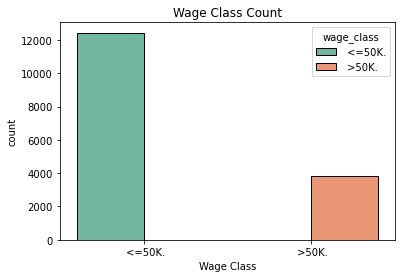

In [12]:
ax=sns.countplot(test['wage_class'],hue=test['wage_class'], edgecolor='k',palette='Set2')
ax.set_title('Wage Class Count')
ax.set_xlabel('Wage Class')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


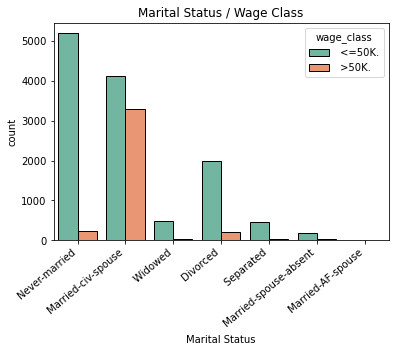

In [13]:
ax=sns.countplot(test['marital_status'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Marital Status / Wage Class')
ax.set_xlabel('Marital Status')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


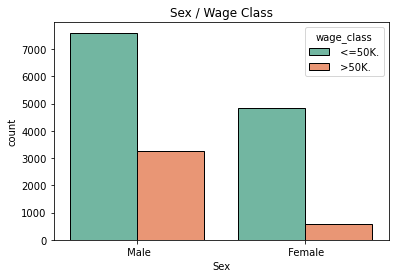

In [14]:
ax=sns.countplot(test['sex'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_title('Sex / Wage Class')
ax.set_xlabel('Sex')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


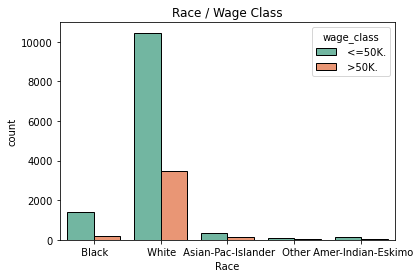

In [15]:
ax=sns.countplot(test['race'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_title('Race / Wage Class')
ax.set_xlabel('Race')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


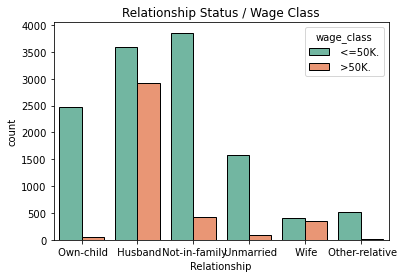

In [16]:
ax=sns.countplot(test['relationship'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_title('Relationship Status / Wage Class')
ax.set_xlabel('Relationship')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


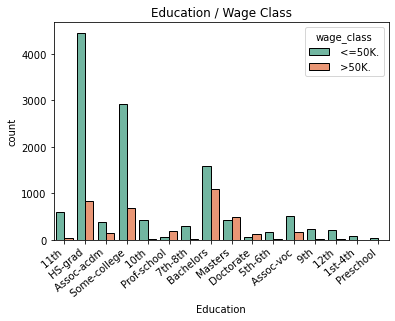

In [17]:
ax=sns.countplot(test['education'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_title('Education / Wage Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Education')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


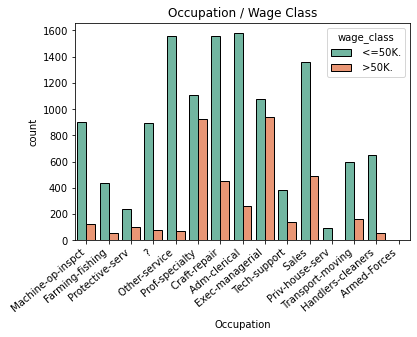

In [18]:
ax=sns.countplot(test['occupation'], hue=test['wage_class'],edgecolor='k', palette='Set2')
ax.set_title('Occupation / Wage Class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel('Occupation')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


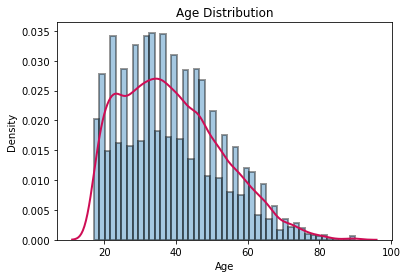

In [19]:
ax=sns.distplot(test['age'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


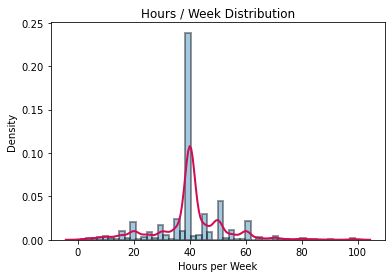

In [20]:
ax=sns.distplot(test['hours_per_week'],hist_kws=dict(edgecolor="k", linewidth=2),kde_kws={"color": "#ce0d55", "lw": 2})
ax.set_title('Hours / Week Distribution')
ax.set_xlabel('Hours per Week')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


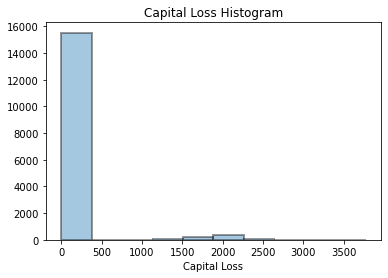

In [21]:
ax=sns.distplot(test['capital_loss'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))
ax.set_title('Capital Loss Histogram')
ax.set_xlabel('Capital Loss')
plt.show()

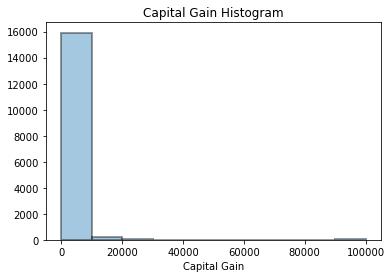

In [22]:
ax=sns.distplot(test['capital_gain'],bins=10,kde=False,hist_kws=dict(edgecolor="k", linewidth=2))
ax.set_title('Capital Gain Histogram')
ax.set_xlabel('Capital Gain')
plt.show()

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


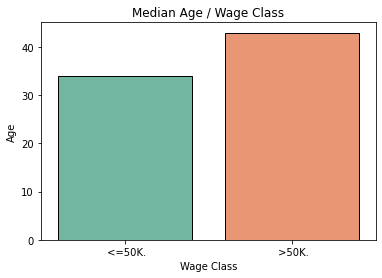

In [23]:
#median age for each wage_class
ax=sns.barplot(test.groupby('wage_class')['age'].median().index,test.groupby('wage_class')['age'].median().values,
               edgecolor='k', palette='Set2')
ax.set_ylabel('Age')
ax.set_xlabel('Wage Class')
ax.set_title('Median Age / Wage Class')
plt.show()

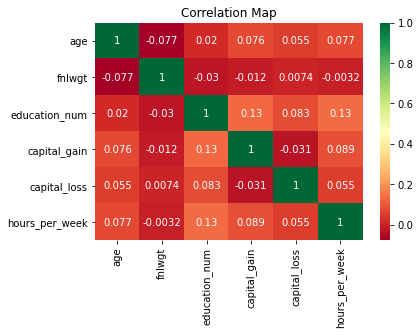

In [24]:
corr_test=test.copy()
for feature in categorical_features_test:
    corr_test.drop(feature,axis=1,inplace=True)

    
ax=sns.heatmap(corr_test.corr(), cmap='RdYlGn',annot=True)
ax.set_title('Correlation Map')
plt.show()

## Feature Engineering

In [25]:
#convert <=50K and >50K to 0, 1 respectively
encoder=LabelEncoder()
train['wage_class']=encoder.fit_transform(train['wage_class'])

In [26]:
categorical_features=[feature for feature in  train.columns if  train[feature].dtype=='O' and feature!='wage_class']
for feature in categorical_features:
    freq=train[feature].value_counts().rename_axis(feature).reset_index(name='frequency')
    print('\n')
    print(freq)



           workclass  frequency
0            Private      22696
1   Self-emp-not-inc       2541
2          Local-gov       2093
3                  ?       1836
4          State-gov       1298
5       Self-emp-inc       1116
6        Federal-gov        960
7        Without-pay         14
8       Never-worked          7


        education  frequency
0         HS-grad      10501
1    Some-college       7291
2       Bachelors       5355
3         Masters       1723
4       Assoc-voc       1382
5            11th       1175
6      Assoc-acdm       1067
7            10th        933
8         7th-8th        646
9     Prof-school        576
10            9th        514
11           12th        433
12      Doctorate        413
13        5th-6th        333
14        1st-4th        168
15      Preschool         51


           marital_status  frequency
0      Married-civ-spouse      14976
1           Never-married      10683
2                Divorced       4443
3               Separated       1

In [27]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
train['native_country']=np.where(train['native_country']==' United-States',1,0)

In [28]:
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
train['workclass']=np.where(train['workclass']==' Private',1,0)

In [29]:
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
train['sex']=np.where(train['sex']==' Male',1,0)

In [30]:
#transform workclass feature to be 1 if the Race is White and 0 if doesn't
train['race']=np.where(train['race']==' White',1,0)

In [31]:
#transform marital status and concatenate some classes to reduce distinct classes
train['marital_status']=train['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',  
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced', 
                                                         ' Divorced':'Divorced', 
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })

In [32]:
#create ordered label for education 
education_mapping={' Preschool':0,' 1st-4th':1,' 5th-6th':2,' 7th-8th':3,' 9th':4,' 10th':5,
                   ' 11th':6,' 12th':7,' HS-grad':8,' Some-college':0,' Assoc-acdm':10,
                   ' Assoc-voc':11, ' Bachelors':12, ' Prof-school':13, ' Masters':14,' Doctorate':15
                   }
train['education']=train['education'].map(education_mapping)

In [33]:
relationship_ordered=train.groupby(['relationship'])['wage_class'].count().sort_values().index
relationship_ordered={k:i for i,k in enumerate(relationship_ordered,0)}
train['relationship']=train['relationship'].map(relationship_ordered)  

In [34]:
occupation_ordered=train.groupby(['occupation'])['wage_class'].count().sort_values().index
occupation_ordered={k:i for i,k in enumerate(occupation_ordered,0)}
train['occupation']=train['occupation'].map(occupation_ordered)

In [35]:
marital_ordered=train.groupby(['marital_status'])['wage_class'].count().sort_values().index
marital_ordered={k:i for i,k in enumerate(marital_ordered,0)}
train['marital_status']=train['marital_status'].map(marital_ordered)

In [36]:
train.head(10)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,0,77516,12,13,2,11,4,1,1,2174,0,40,1,0
1,50,0,83311,12,13,3,12,5,1,1,0,0,13,1,0
2,38,1,215646,8,9,1,5,4,1,1,0,0,40,1,0
3,53,1,234721,6,7,3,5,5,0,1,0,0,40,1,0
4,28,1,338409,12,13,3,14,1,0,0,0,0,40,0,0
5,37,1,284582,14,14,3,12,1,1,0,0,0,40,1,0
6,49,1,160187,4,5,1,9,4,0,0,0,0,16,0,0
7,52,0,209642,8,9,3,12,5,1,1,0,0,45,1,1
8,31,1,45781,14,14,2,14,4,1,0,14084,0,50,1,1
9,42,1,159449,12,13,3,12,5,1,1,5178,0,40,1,1


In [37]:
train.isnull().sum()


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [38]:
train.drop('fnlwgt',axis=1,inplace=True) # it is not a useful feature for predicting the wage class

In [39]:
#Separating the feature and the Label columns 
x=train.drop(labels='wage_class', axis=1)
y= train['wage_class']

In [40]:
# as the datapoints differ a lot in magnitude, we'll scale them
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(x)

In [41]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(scaled_data,y,test_size=0.3,random_state=42)

In [42]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
accuracy

0.8975517725517725

In [44]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
accuracy

0.8685638243423073

#### Test Set

In [45]:
test['wage_class']=np.where(test['wage_class']== ' >50K.',1,0)

In [46]:
test['wage_class'].value_counts()

0    12435
1     3846
Name: wage_class, dtype: int64

In [47]:
#transform country feature to be 1 if country is the United States. Otherwise is equal to 0
test['native_country']=np.where(test['native_country']==' United-States',1,0)

In [48]:
#transform workclass feature to be 1 if the workclass is Private and 0 if doesn't
test['workclass']=np.where(test['workclass']==' Private',1,0)

In [49]:
#transform workclass feature to be 1 if the Sex is Male and 0 if doesn't
test['sex']=np.where(test['sex']==' Male',1,0)

In [50]:
test['race']=np.where(test['race']==' White',1,0)


In [51]:
test['education']=test['education'].map(education_mapping)

In [52]:
test['relationship']=test['relationship'].map(relationship_ordered) 

In [53]:
test['occupation']=test['occupation'].map(occupation_ordered)

In [54]:
#transform marital status and concatenate some classes to reduce distinct classes
test['marital_status']=test['marital_status'].replace({' Married-civ-spouse': 'Married', ' Never-married': 'Single',  
                                                        ' Separated':'Divorced', ' Married-spouse-absent' : 'Divorced', 
                                                         ' Divorced':'Divorced', 
                                                         ' Married-AF-spouse' :'Divorced', ' Widowed':'Widowed' })

In [55]:
test['marital_status']=test['marital_status'].map(marital_ordered)


In [56]:
test.head(10)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,1,226802,6,7,2,8,3,0,1,0,0,40,1,0
1,38,1,89814,8,9,3,4,5,1,1,0,0,50,1,0
2,28,0,336951,10,12,3,2,5,1,1,0,0,40,1,1
3,44,1,160323,0,10,3,8,5,0,1,7688,0,40,1,1
4,18,0,103497,0,10,2,7,3,1,0,0,0,30,1,0
5,34,1,198693,5,6,2,9,4,1,1,0,0,30,1,0
6,29,0,227026,8,9,2,7,2,0,1,0,0,40,1,0
7,63,0,104626,13,15,3,14,5,1,1,3103,0,32,1,1
8,24,1,369667,0,10,2,9,2,1,0,0,0,40,1,0
9,55,1,104996,3,4,3,13,5,1,1,0,0,10,1,0


In [57]:
test.isnull().sum()


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [58]:
test.drop('fnlwgt',axis=1,inplace=True)


In [59]:
#Separating the feature and the Label columns 
x=test.drop(labels='wage_class', axis=1)
y= test['wage_class']

In [60]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

C:\Users\Sagar Suraj Shirke\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:26:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
accuracy

0.8975517725517725

In [62]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
accuracy

0.8685638243423073